In [2]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.adatabase import ADatabase
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functional.backtester import Backtester as b

In [3]:
start_date = datetime(2020,1,1)
end_date = datetime(2023,1,1)

In [4]:
market = Market()
speculation_db = ADatabase("class_spec")

In [5]:
market.connect()
sp500 = market.retrieve("sp500")
market.disconnect()
sp500 = sp500.rename(columns={"Symbol":"ticker"})

In [6]:
speculation_db.connect()
t = speculation_db.retrieve("trades")
speculation_db.disconnect()
t["holding"] = [(row[1]["sell_date"] - row[1]["date"]).days for row in t.iterrows()]

In [7]:
reqs = [0.05,0.1,0.15]
signals = [0.05,0.1,0.15]
values = [True,False]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
hedges = [True,False]
parameters = []
positions = 10
training_year = 4
for value in values:
    for classification in classifications:
        for ceiling in ceilings:
            for floor in floors:
                for hedge in hedges:
                    for signal in signals:
                        for req in reqs:
                            parameter = {"value":value
                                         ,"classification":classification
                                         ,"ceiling":ceiling
                                         ,"floor":floor
                                         ,"hedge":hedge
                                         ,"signal":signal
                                         ,"req":req
                                         ,"training_years":training_year}
                            parameters.append(parameter)

In [8]:
analysis = []
for parameter in parameters:
    for position in range(positions):
        position_trades = t[(t["position"]==position)].sort_values("date")
        for key in parameter.keys():
            position_trades = position_trades[position_trades[key]==parameter[key]]
        initial = 100 / positions
        for delta in position_trades["delta"]:
            initial = initial * (1+delta)
        if position_trades.index.size > 0:
            wr = position_trades[position_trades["delta"]>0].index.size / position_trades.index.size
            analysis_dict = {}
            for key in parameter.keys():
                analysis_dict[key] = parameter[key]
            analysis_dict["position"]=position
            analysis_dict["holding"]=position_trades["holding"].mean()
            analysis_dict["wr"]=wr
            analysis_dict["pv"]=initial
            analysis.append(analysis_dict)
a = pd.DataFrame(analysis)

In [9]:
a

,value,classification,ceiling,floor,hedge,signal,req,training_years,position,holding,wr,pv
0,True,True,True,True,True,0.05,0.05,4,0,3.292208,0.571429,20.245805
1,True,True,True,True,True,0.05,0.05,4,1,3.350649,0.558442,15.621389
2,True,True,True,True,True,0.05,0.05,4,2,3.274510,0.496732,12.726487
3,True,True,True,True,True,0.05,0.05,4,3,3.386667,0.500000,9.560596
4,True,True,True,True,True,0.05,0.05,4,4,3.362416,0.550336,14.651724
...,...,...,...,...,...,...,...,...,...,...,...,...
2779,False,False,False,False,False,0.15,0.15,4,5,4.000000,0.125000,5.678923
2780,False,False,False,False,False,0.15,0.15,4,6,4.333333,0.000000,5.841812
2781,False,False,False,False,False,0.15,0.15,4,7,4.166667,0.000000,6.650081
2782,False,False,False,False,False,0.15,0.15,4,8,3.833333,0.333333,6.565604


In [10]:
indexer = list(parameters[0].keys())
complete = a.pivot_table(index=indexer,columns="position",values="pv",fill_value=100/positions).reset_index()
complete["pv"] = [sum([row[1][i] for i in range(positions)]) for row in complete.iterrows()]
complete[indexer + ["pv"]].sort_values("pv",ascending=False)

position,value,classification,ceiling,floor,hedge,signal,req,training_years,pv
164,True,False,False,True,False,0.05,0.15,4,552.361684
200,True,False,True,True,False,0.05,0.15,4,543.227995
236,True,True,False,True,False,0.05,0.15,4,459.054148
272,True,True,True,True,False,0.05,0.15,4,434.659759
167,True,False,False,True,False,0.10,0.15,4,430.091761
...,...,...,...,...,...,...,...,...,...
44,False,False,True,False,False,0.15,0.15,4,69.554289
42,False,False,True,False,False,0.15,0.05,4,68.027077
6,False,False,False,False,False,0.15,0.05,4,68.027077
7,False,False,False,False,False,0.15,0.10,4,65.960018


In [23]:
top = complete.sort_values("pv",ascending=False).iloc[3]
analysis = t
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["date","sell_date","ticker","adjclose","sell_price","delta","projected_delta","position"]]
ledger["delta"] = ledger["delta"] + 1
ledger = ledger.merge(sp500[["ticker","GICS Sector"]],on="ticker",how="left")

In [24]:
ledger["non_hedged_delta"] = 1 + (ledger["sell_price"]-ledger["adjclose"] ) / (ledger["adjclose"] ) 

In [25]:
ledger["delta"].min()

0.9499999999999998

In [28]:
ledger.sort_values(["date","projected_delta"]).head(30)

,date,sell_date,ticker,adjclose,sell_price,delta,projected_delta,position,GICS Sector,non_hedged_delta
904,2020-01-06,2020-01-10,APTV,92.126072,89.292958,0.969247,0.050787,6,Consumer Discretionary,0.969247
760,2020-01-06,2020-01-10,FCX,12.537280,12.586063,1.003891,0.050822,5,Materials,1.003891
611,2020-01-06,2020-01-10,FITB,26.846043,26.463671,0.985757,0.053481,4,Financials,0.985757
461,2020-01-06,2020-01-10,HBAN,12.607423,12.443016,0.986960,0.053868,3,Financials,0.986960
308,2020-01-06,2020-01-10,KMX,87.050000,89.090000,1.023435,0.054100,2,Consumer Discretionary,1.023435
154,2020-01-06,2020-01-10,UAA,20.440000,19.770000,0.967221,0.054681,1,Consumer Discretionary,0.967221
0,2020-01-06,2020-01-10,LKQ,34.027279,33.275672,0.977912,0.058582,0,Consumer Discretionary,0.977912
1325,2020-01-07,2020-01-10,KEY,17.137767,17.128961,0.999486,0.057713,9,Financials,0.999486
1188,2020-01-07,2020-01-10,GM,34.555201,34.063662,0.985775,0.059979,8,Consumer Discretionary,0.985775
1048,2020-01-07,2020-01-10,KHC,26.735685,26.683534,0.998049,0.062641,7,Consumer Staples,0.998049


In [15]:
ledger["projected_delta"].mean()

0.14035514639779764

In [16]:
metric = "position"

In [17]:
portfolio = ledger.pivot_table(index="sell_date",columns=metric,values="delta").fillna(1).reset_index()
portfolio.reset_index()

position,index,sell_date,0,1,2,3,4,5,6,7,8,9
0,0,2020-01-10,0.988751,0.977912,0.986401,1.000000,0.997263,1.009825,0.967221,1.000910,1.023435,0.986960
1,1,2020-01-17,1.039860,1.078406,1.006474,0.995586,1.006983,1.044099,1.008130,1.017289,1.029931,1.008842
2,2,2020-01-24,0.950000,0.964955,1.002455,0.986130,0.990604,1.005719,0.988884,0.968065,0.950000,1.004323
3,3,2020-01-31,1.018349,1.018323,1.016507,0.972626,1.005575,1.016727,0.986749,1.001454,0.971534,1.006522
4,4,2020-02-07,1.049274,1.041754,1.038368,0.982633,0.987135,1.015286,1.084514,1.015873,1.010683,1.012196
...,...,...,...,...,...,...,...,...,...,...,...,...
285,285,2022-12-16,0.973022,0.972747,0.950000,0.950413,1.000000,0.970840,0.968530,1.000000,1.066753,1.045190
286,286,2022-12-20,1.000000,1.000000,1.000000,1.000000,1.000000,0.950000,1.000000,1.000000,1.000000,1.000000
287,287,2022-12-23,0.990548,0.991351,1.030438,0.950988,1.090672,1.000000,0.984634,0.965389,1.035634,1.021638
288,288,2022-12-28,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.950000,1.000000


In [18]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date"] = portfolio["sell_date"]
cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
cumulative

,0,1,2,3,4,5,6,7,8,9,date,pv,adjclose,bench
0,0.988751,0.977912,0.986401,1.000000,0.997263,1.009825,0.967221,1.000910,1.023435,0.986960,2020-01-10,0.993868,310.495697,1.000000
1,1.028162,1.054586,0.992787,0.995586,1.004227,1.054357,0.975085,1.018215,1.054068,0.995686,2020-01-17,1.017276,316.444214,1.019158
2,0.976754,1.017628,0.995225,0.981777,0.994791,1.060387,0.964246,0.985698,1.001364,0.999991,2020-01-24,0.997786,313.412720,1.009395
3,0.994676,1.036273,1.011653,0.954902,1.000337,1.078125,0.951469,0.987132,0.972860,1.006512,2020-01-31,0.999394,306.701599,0.987781
4,1.043688,1.079542,1.050468,0.938318,0.987467,1.094605,1.031881,1.002800,0.983253,1.018788,2020-02-07,1.023081,316.682495,1.019926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,7.470225,13.782837,8.850459,4.065599,2.498887,2.964416,1.911117,4.225355,4.406287,3.654708,2022-12-16,5.382989,383.269989,1.234381
286,7.470225,13.782837,8.850459,4.065599,2.498887,2.816195,1.911117,4.225355,4.406287,3.654708,2022-12-20,5.368167,380.540009,1.225589
287,7.399618,13.663634,9.119847,3.866334,2.725465,2.816195,1.881750,4.079113,4.563302,3.733788,2022-12-23,5.384905,382.910004,1.233222
288,7.399618,13.663634,9.119847,3.866334,2.725465,2.816195,1.881750,4.079113,4.335137,3.733788,2022-12-28,5.362088,376.660004,1.213093


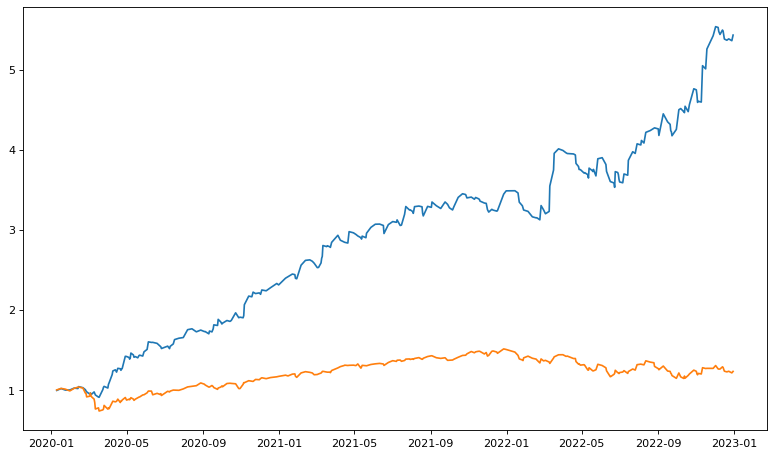

In [19]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])

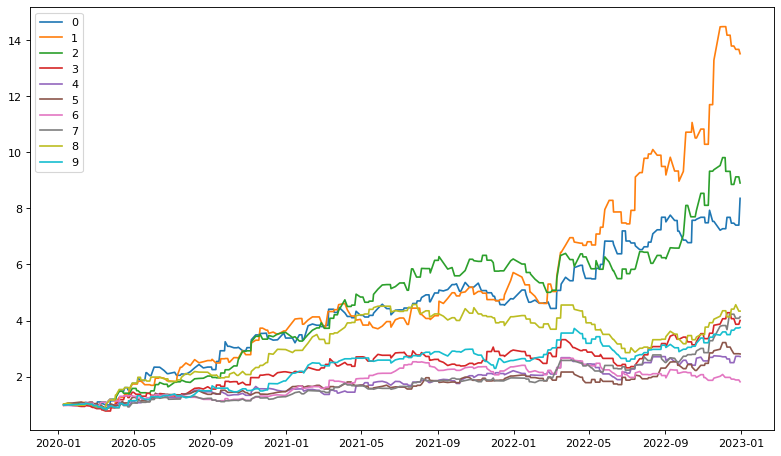

In [20]:
plt.figure(figsize=(12, 7), dpi=80)
for i in counted_columns:
    position = cumulative[i]
    plt.plot(cumulative["date"],position)
    plt.legend(counted_columns)
plt.show()


In [21]:
ledger.groupby(["GICS Sector"]).mean().sort_values("delta",ascending=False)

,adjclose,sell_price,delta,projected_delta,position,non_hedged_delta
GICS Sector,,,,,,
Consumer Staples,83.043090,85.061103,1.018940,0.085088,5.384615,1.018940
Energy,24.395822,24.738581,1.016162,0.189993,4.600000,1.016162
Consumer Discretionary,664.128418,669.604034,1.014757,0.169108,3.886256,1.014757
Information Technology,179.944142,182.649196,1.012770,0.116477,4.521978,1.012770
Communication Services,180.380301,181.775699,1.011467,0.135009,3.828571,1.011467
Financials,233.146593,234.156343,1.010338,0.106284,5.447619,1.010338
Industrials,101.077563,101.331368,1.009757,0.144214,4.728155,1.009757
Materials,85.351412,86.235687,1.007120,0.093678,4.983333,1.007120
Health Care,258.880922,260.791015,1.006579,0.108695,4.413043,1.006579


In [22]:
industry_analysis = ledger.pivot_table(index="sell_date",columns="GICS Sector",values="delta").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x != "sell_date"]].cumprod()

GICS Sector,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,1.000000,0.994598,1.000000,1.000000,0.986960,0.988751,1.000000,1.000000,0.994858,1.000000,1.000000
1,1.000000,1.020051,1.006474,1.008842,1.004023,1.049314,1.001858,1.000000,0.994858,1.000000,1.000000
2,1.000000,1.014229,1.006474,0.977009,0.992863,1.049314,1.006189,0.990604,0.959994,1.000000,1.000000
3,0.971534,1.022800,1.006474,0.957164,1.004295,1.049314,1.006189,1.007174,0.977608,1.000000,1.000000
4,1.019406,1.035842,1.006474,0.983976,1.004295,1.049314,1.016938,1.019458,0.977608,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
284,2.160627,5.249048,1.543901,3.320754,2.373693,1.220232,1.222350,1.807690,1.354508,1.155404,1.012687
285,2.160627,4.986595,1.543901,3.320754,2.373693,1.220232,1.222350,1.807690,1.354508,1.155404,1.012687
286,2.191526,4.953745,1.543901,3.320754,2.445943,1.220232,1.222350,1.807690,1.354508,1.155404,1.012687
287,2.191526,4.953745,1.543901,3.320754,2.445943,1.220232,1.161233,1.807690,1.354508,1.155404,1.012687
